Step 0: Load The Data

In [1]:
import pickle
import pandas as pd

training_file = "train.p"
validation_file = "valid.p"
testing_file = "test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

# features and labels
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

# Sign id<->name mapping
sign_names = pd.read_csv('signnames.csv').to_dict(orient='index')
sign_names = { key : val['SignName'] for key, val in sign_names.items() }

Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

1. 'features' is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
2. 'labels' is a 1D array containing the label/class id of the traffic sign. The file signnames.csv contains id -> name mappings for each id.
3. 'sizes' is a list containing tuples, (width, height) representing the original width and height the image.
4. 'coords' is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES.


A Basic Summary of the Dataset

In [2]:
import numpy as np

n_train = len(X_train)

n_test = len(X_test)

n_valid = len(X_valid)

image_shape = X_train.shape[1:]

n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Number of validation examples =", n_valid)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Number of validation examples = 4410
Image data shape = (32, 32, 3)
Number of classes = 43


An Exploratory Visualization of the Dataset

Number of Samples in Each Category

The categories with minimum/maximum number of samples are marked with yellow/red color correspondingly.

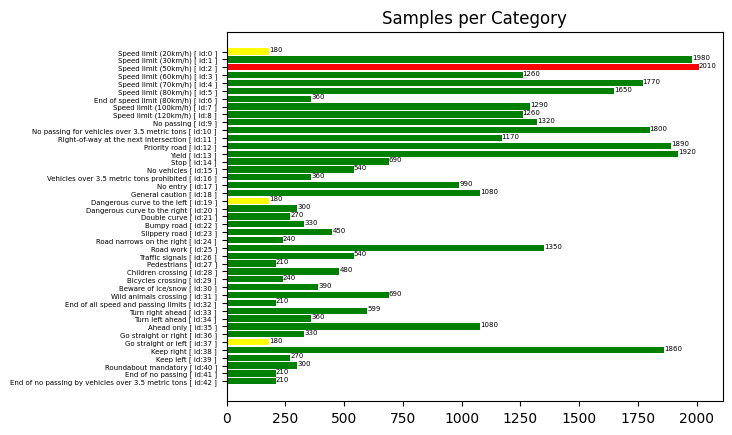

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

plt.rcdefaults()
fig, ax = plt.subplots()

samples_per_category = [len(np.where(y_train==cat_id)[0]) for cat_id in sign_names.keys()]
category_names = tuple([val + " [ id:{id} ]".format(id=key) for key,val in sign_names.items()])

min_cnt = min(samples_per_category)
max_cnt = max(samples_per_category)

y_pos = np.arange(len(category_names))

rects = ax.barh(y_pos, 
                samples_per_category, 
                align='center', 
                color=['green' if val != min_cnt and val != max_cnt \
                       else 'yellow' if val == min_cnt \
                       else 'red' for val in samples_per_category])

for i in range(0,len(rects)):
    ax.text(int(rects[i].get_width()), 
            int(rects[i].get_y()+rects[i].get_height()/2.0),
            samples_per_category[i],
            fontproperties=fm.FontProperties(size=5))

ax.set_yticks(y_pos)
ax.set_yticklabels(category_names,fontproperties=fm.FontProperties(size=5))
ax.invert_yaxis()
ax.set_title('Samples per Category')

plt.show()

Random Image from Each Category

Output a sample image from each category. Note, that images will be transformed before they are passed to neural network.

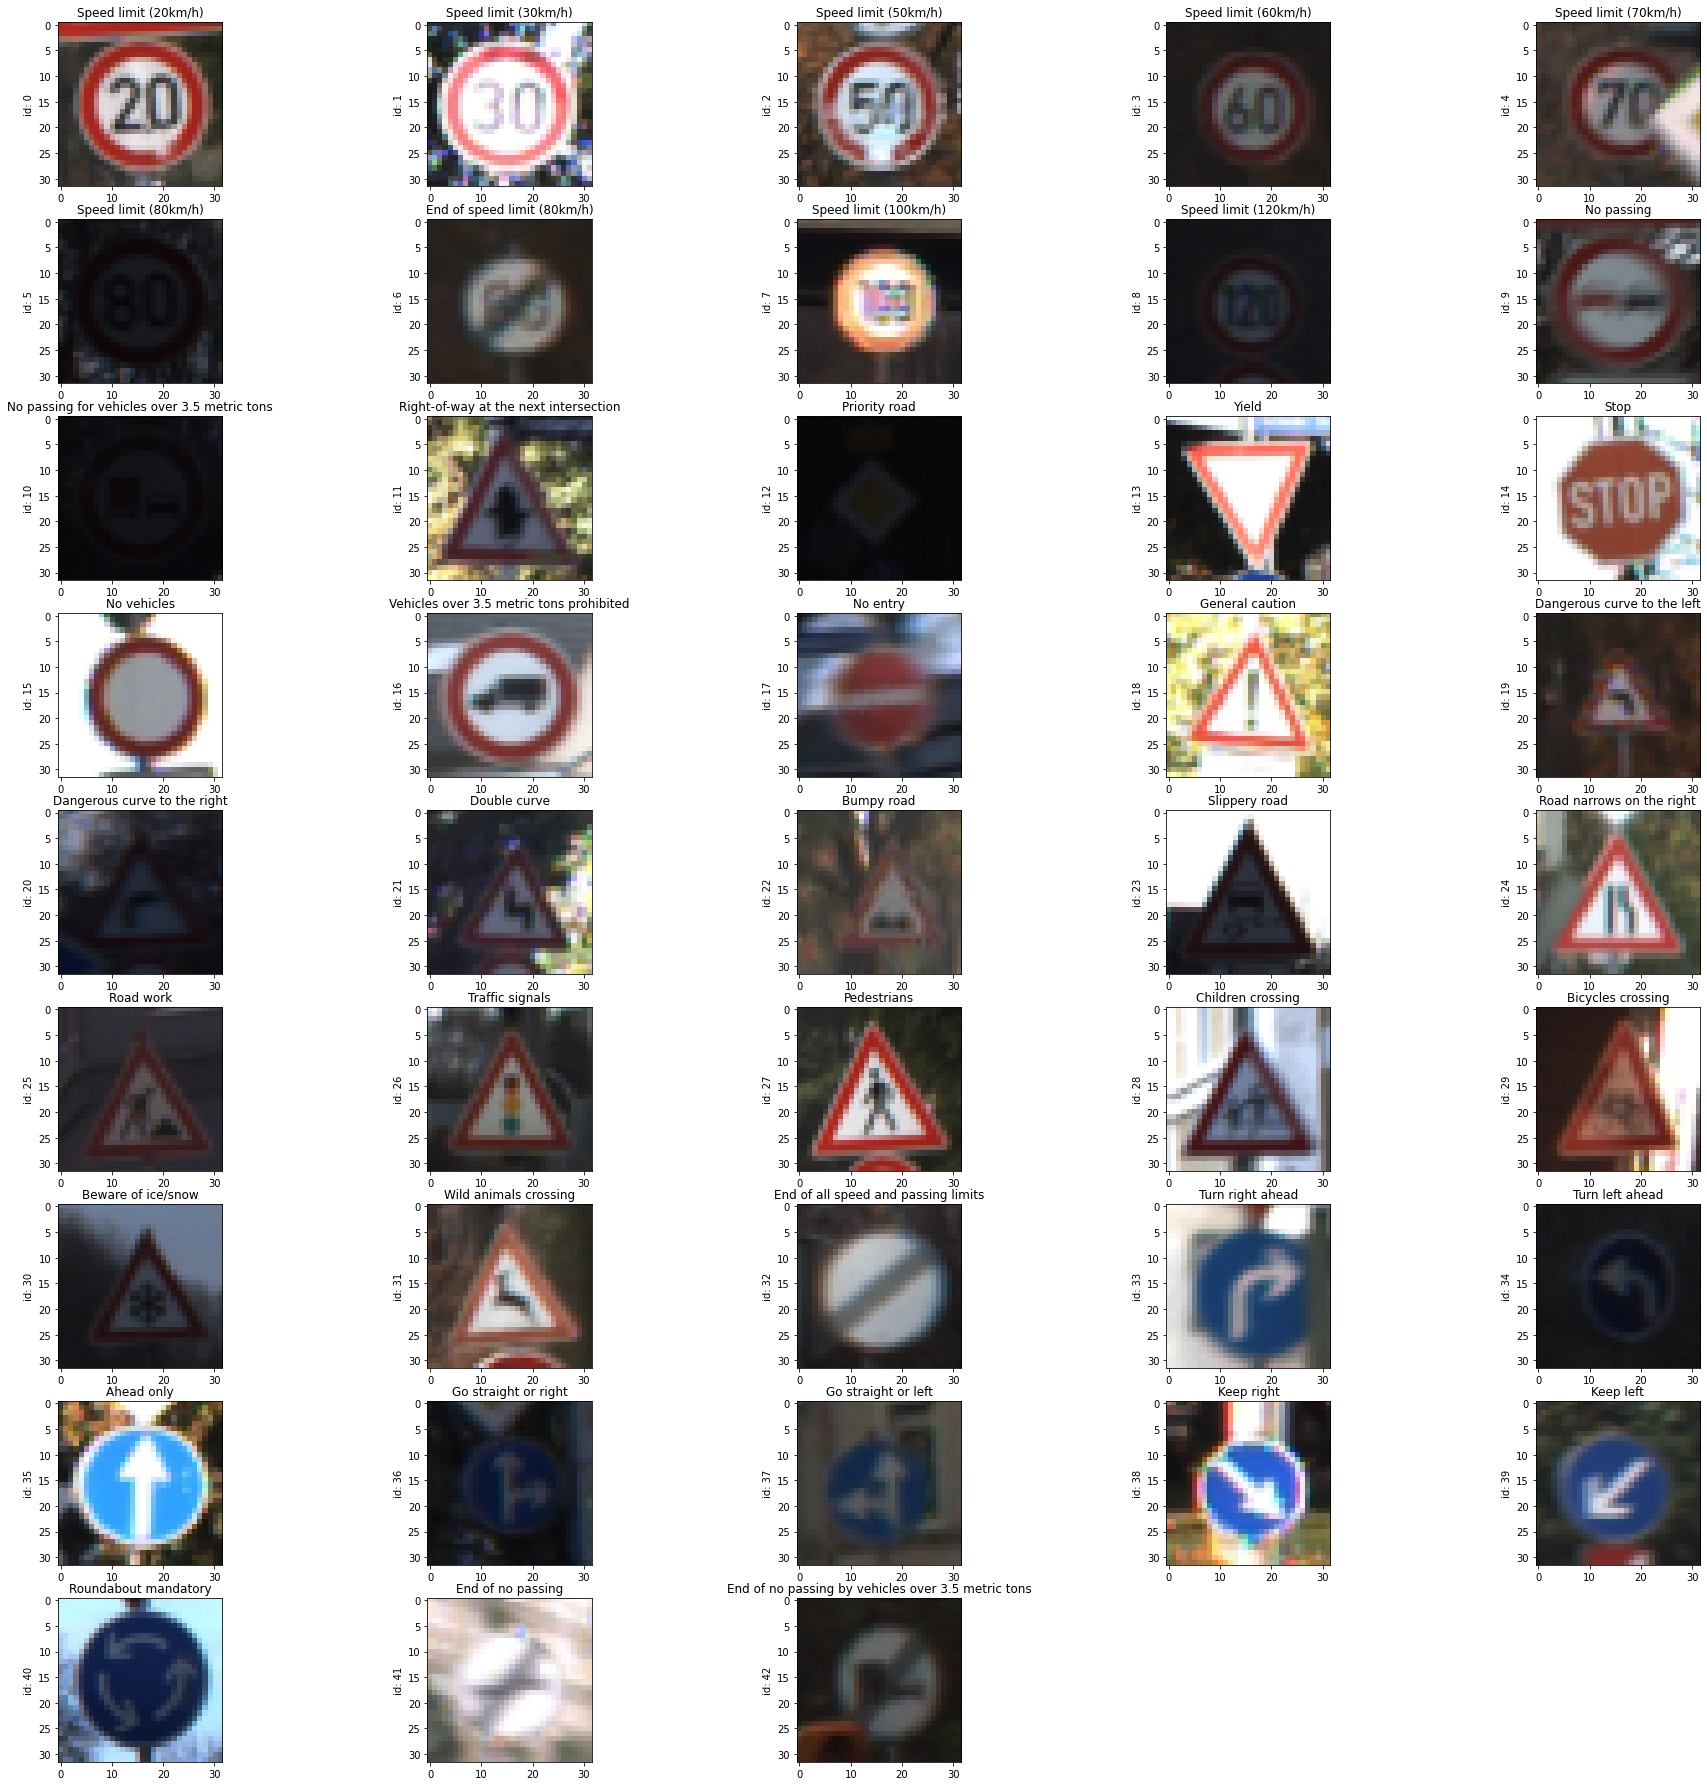

In [4]:
import random
import numpy as np
import matplotlib.pyplot as plt
import math

%matplotlib inline

h_or_w = image_shape[0]
fig = plt.figure(figsize=(h_or_w,h_or_w))
for i in range(0, n_classes):
    samples = np.where(y_train==i)[0]
    index = random.randint(0, len(samples) - 1)
    image = X_train[samples[index]]
    
    ax = fig.add_subplot(math.ceil(n_classes/5), 5, i+1)
    ax.set_title(sign_names[i])
    ax.set_ylabel("id: {id}".format(id=i))
    plt.imshow(image)
plt.show()

Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. The LeNet-5 CNN architecture is used here with minor modifications: dropout parameter added to the first fully connected layer.

Pre-process the Data Set (normalization, grayscale, etc.)

Shuffle Data

In [5]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)


Prepare Input Images

In [6]:
import cv2

def prepare_image(image_set):

    new_shape = image_shape[0:2] + (1,)
    
    prep_image_set = np.empty(shape=(len(image_set),) + new_shape, dtype=int)
    
    for ind in range(0, len(image_set)):
        norm_img = cv2.normalize(image_set[ind], np.zeros(image_shape[0:2]), 0, 255, cv2.NORM_MINMAX)
        
        gray_img = cv2.cvtColor(norm_img, cv2.COLOR_RGB2GRAY)
        
        prep_image_set[ind] = np.reshape(gray_img, new_shape)
        
    return prep_image_set
        
def equalize_number_of_samples(image_set, image_labels):

    num = max([len(np.where(image_labels==cat_id)[0]) for cat_id in sign_names.keys()])
    
    equalized_image_set = np.empty(shape=(num * n_classes,) + image_set.shape[1:], dtype=int)
    equalized_image_labels = np.empty(shape=(num * n_classes,), dtype=int)
    j = 0
    
    for cat_id in sign_names.keys():
        cat_inds = np.where(y_train==cat_id)[0]
        cat_inds_len = len(cat_inds)
    
        for i in range(0, num):
            equalized_image_set[j] = image_set[cat_inds[i % cat_inds_len]]
            equalized_image_labels[j] = image_labels[cat_inds[i % cat_inds_len]]
            j += 1
    
    return shuffle(equalized_image_set, equalized_image_labels)
X_train_prep = prepare_image(X_train)
X_test_prep = prepare_image(X_test)
X_valid_prep = prepare_image(X_valid)

X_train_prep, y_train_prep = equalize_number_of_samples(X_train_prep, y_train)
y_test_prep = y_test
y_valid_prep = y_valid

image_shape_prep = X_train_prep[0].shape


Model Architecture

In [7]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten

def LeNet(x, channels, classes, keep_prob, mu=0, sigma=0.01):    
    

    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, channels, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    conv1 = tf.nn.relu(conv1)

   
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
 
    conv2 = tf.nn.relu(conv2)

    
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

  
    fc0   = flatten(conv2)
    fc0   = tf.nn.dropout(fc0, keep_prob=keep_prob)
    
   
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
  
    fc1    = tf.nn.relu(fc1)

   
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    
    fc2    = tf.nn.relu(fc2)
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, classes), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(classes))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

/home/gunjan/SDC/my-project-env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/gunjan/SDC/my-project-env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/gunjan/SDC/my-project-env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/gunjan/SDC/my-project-env/lib/python3.6/site-pack

Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

Features and Labels

In [8]:
x = tf.placeholder(tf.float32, (None,) + image_shape_prep)


y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

Training Pipeline

In [9]:
RATE = 0.0008
EPOCHS = 30
BATCH_SIZE = 128
KEEP_PROB = 0.7
STDDEV = 0.01

keep_prob = tf.placeholder(tf.float32)
logits = LeNet(x, image_shape_prep[-1], n_classes, keep_prob, sigma=STDDEV)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = RATE)
training_operation = optimizer.minimize(loss_operation)

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.




Model Evaluation

In [10]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples


Train the Model

In [11]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_prep)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train_prep, y_train_prep = shuffle(X_train_prep, y_train_prep)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_prep[offset:end], y_train_prep[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: KEEP_PROB})
            
        train_accuracy = evaluate(X_train_prep, y_train_prep)    
        validation_accuracy = evaluate(X_valid_prep, y_valid_prep)
        print("EPOCH {} ...".format(i+1))
        print("Train Accuracy = {:.3f}".format(train_accuracy))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './model.ckpt')
    print("Model saved")

Training...

EPOCH 1 ...
Train Accuracy = 0.876
Validation Accuracy = 0.785

EPOCH 2 ...
Train Accuracy = 0.961
Validation Accuracy = 0.884

EPOCH 3 ...
Train Accuracy = 0.976
Validation Accuracy = 0.886

EPOCH 4 ...
Train Accuracy = 0.979
Validation Accuracy = 0.921

EPOCH 5 ...
Train Accuracy = 0.986
Validation Accuracy = 0.909

EPOCH 6 ...
Train Accuracy = 0.989
Validation Accuracy = 0.920

EPOCH 7 ...
Train Accuracy = 0.992
Validation Accuracy = 0.912

EPOCH 8 ...
Train Accuracy = 0.994
Validation Accuracy = 0.934

EPOCH 9 ...
Train Accuracy = 0.994
Validation Accuracy = 0.930

EPOCH 10 ...
Train Accuracy = 0.993
Validation Accuracy = 0.929

EPOCH 11 ...
Train Accuracy = 0.991
Validation Accuracy = 0.918

EPOCH 12 ...
Train Accuracy = 0.996
Validation Accuracy = 0.947

EPOCH 13 ...
Train Accuracy = 0.994
Validation Accuracy = 0.940

EPOCH 14 ...
Train Accuracy = 0.996
Validation Accuracy = 0.944

EPOCH 15 ...
Train Accuracy = 0.995
Validation Accuracy = 0.938

EPOCH 16 ...
Train Ac

Evaluate Trained Model Using Test Samples

In [12]:
with tf.Session() as sess:
    saver.restore(sess, './model.ckpt')

    test_accuracy = evaluate(X_test_prep, y_test_prep)
    print("Test Accuracy = {:.3f}".format(test_accuracy))


Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./model.ckpt
Test Accuracy = 0.917


Step 3: Test a Model on New Images

It is time to apply the trained model to the German trafic sign images that were obtained from the Internet.

Load and Output the Images

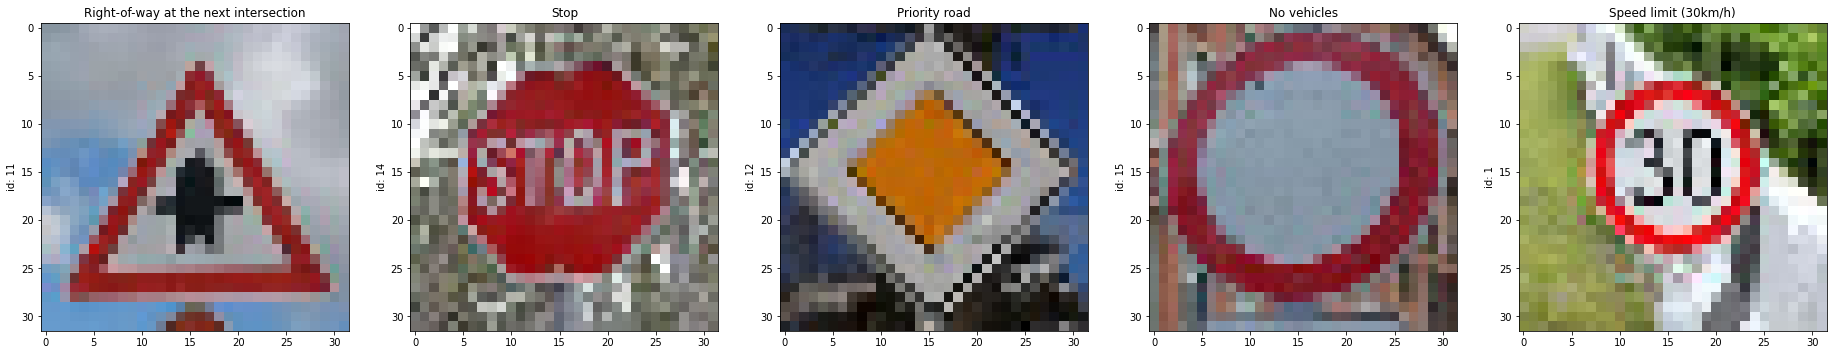

In [16]:
import os
import cv2
import matplotlib.image as mpimg

img_paths = os.listdir("traffic-sign-images")
images = list()
labels = list()


for img_path in img_paths:

    img = mpimg.imread(os.path.join("traffic-sign-images", img_path))
    img = cv2.resize(img, image_shape[0:2], interpolation=cv2.INTER_CUBIC)
    images.append(img)
    

    labels.append(int(img_path[0:img_path.find('-')]))
images = np.array(images)
labels = np.array(labels)
    

h_or_w = image_shape[0]
fig = plt.figure(figsize=(h_or_w,h_or_w))
for i in range(0, len(images)):
    ax = fig.add_subplot(1, len(images), i+1)
    ax.set_title(sign_names[labels[i]])
    ax.set_ylabel("id: {id}".format(id=labels[i]))
    plt.imshow(images[i])
plt.show()

Predict the Sign Type for Each Image

In [17]:
images_prep = prepare_image(images)
labels_prep = labels

with tf.Session() as sess:
    saver.restore(sess, './model.ckpt')
    sign_ids = sess.run(tf.argmax(logits, 1), feed_dict={x: images_prep, y: labels_prep, keep_prob: 1})

print('-' * 93)
print("| {p:^43} | {a:^43} |".format(p='PREDICTED', a='ACTUAL'))
print('-' * 93)
for i in range(len(sign_ids)):
    print('| {p:^2} {strp:^40} | {a:^2} {stra:^40} |'.format(
        p=sign_ids[i], strp=sign_names[sign_ids[i]], a=labels[i], stra=sign_names[labels[i]]))
print('-' * 93)

INFO:tensorflow:Restoring parameters from ./model.ckpt
---------------------------------------------------------------------------------------------
|                  PREDICTED                  |                   ACTUAL                    |
---------------------------------------------------------------------------------------------
| 11  Right-of-way at the next intersection   | 11  Right-of-way at the next intersection   |
| 14                   Stop                   | 14                   Stop                   |
| 12              Priority road               | 12              Priority road               |
| 12              Priority road               | 15               No vehicles                |
| 1            Speed limit (30km/h)           | 1            Speed limit (30km/h)           |
---------------------------------------------------------------------------------------------


Analyze Performance

In [18]:
with tf.Session() as sess:
    saver.restore(sess, './model.ckpt')

    test_accuracy = evaluate(images_prep, labels_prep)
    print("Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./model.ckpt
Accuracy = 0.800


Top 5 Softmax Probabilities For Each Image Found on the Web

INFO:tensorflow:Restoring parameters from ./model.ckpt
TopKV2(values=array([[1.0000000e+00, 2.1375342e-19, 2.4845799e-21, 5.7732274e-22,
        1.8308048e-22],
       [9.9528754e-01, 4.4946210e-03, 1.8801728e-04, 1.5650237e-05,
        4.1355970e-06],
       [1.0000000e+00, 4.0426901e-10, 8.0028512e-11, 2.2520699e-11,
        4.9824624e-12],
       [5.6572098e-01, 2.2902580e-01, 1.4478561e-01, 3.9951548e-02,
        1.1363748e-02],
       [9.8585641e-01, 3.5862329e-03, 3.1675028e-03, 2.8200469e-03,
        2.6897506e-03]], dtype=float32), indices=array([[11, 30, 21, 23, 12],
       [14, 17, 13, 38, 34],
       [12, 13,  9,  1, 26],
       [12, 25, 14, 38, 13],
       [ 1, 11,  4,  2, 18]], dtype=int32))


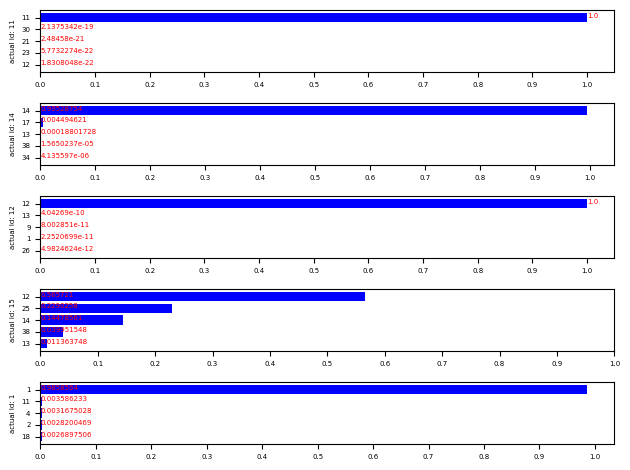

In [19]:
with tf.Session() as sess:
    saver.restore(sess, './model.ckpt')
    top_k = sess.run(tf.nn.top_k(tf.nn.softmax(logits), k=5), 
                     feed_dict={x: images_prep, y: labels_prep, keep_prob: 1})
print(top_k)

plt.rcdefaults()

h_or_w = image_shape[0]
fig = plt.figure()
for i in range(0, len(images)):
    ax = fig.add_subplot(len(images), 1, i+1)
    probabilities = top_k.values[i]
    y_pos = np.arange(len(probabilities))
    ax.set_ylabel("actual id: {id}".format(id=labels[i]), fontproperties=fm.FontProperties(size=5))
    rects = ax.barh(y_pos, 
                probabilities, 
                align='center', 
                color='blue')
    for j in range(0,len(rects)):
        ax.text(int(rects[j].get_width()), 
                int(rects[j].get_y()+rects[j].get_height()/2.0),
                probabilities[j],
                fontproperties=fm.FontProperties(size=5), color='red')

    ax.set_yticks(y_pos)
    ax.set_yticklabels(top_k.indices[i], fontproperties=fm.FontProperties(size=5))
    
    xticks = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks, fontproperties=fm.FontProperties(size=5))
    ax.invert_yaxis()
plt.tight_layout()
plt.show()